# Wavelet-regularized potential reconstruction

__last update__: 13/05/22

In [1]:
%config InlineBackend.figure_format = 'retina'

import os
import time
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import powerbox as pbox
from astropy.io import fits
import pickle as pkl
from PIL import Image
from tqdm import tqdm
from matplotlib.colors import LogNorm, TwoSlopeNorm, Normalize
%matplotlib inline
plt.rc('image', interpolation='none')

import jax.numpy as jnp

from herculens.Coordinates.pixel_grid import PixelGrid
from herculens.Instrument.psf import PSF
from herculens.Instrument.noise import Noise
from herculens.LightModel.light_model import LightModel
from herculens.LensModel.lens_model import LensModel
from herculens.LensImage.lens_image import LensImage
from herculens.Parameters.parameters import Parameters
from herculens.Inference.loss import Loss
from herculens.Inference.optimization import Optimizer
from herculens.Parameters.covariance import FisherCovariance
from herculens.Analysis.plot import Plotter
from herculens.Util import param_util, model_util, grf_util, util, plot_util, jax_util

## Global settings

In [2]:
# Save figures on disk?
SAVE_MODELS = False
SAVE_PSI_FIELDS = False  # for use with MOLET
SAVE_ANIM = False
stop_after_optim = True

# Type of the potential perturbations that we seek to recover
perturbation_type = 'dark_halo' # supported choices: 'dark_halo', 'GRF', 'discyness', 'boxyness'

# Factor of pixel scale for the potential grid
potential_pixel_scale = 1.5

# Plotting engine for modeling results
plotter = Plotter(base_fontsize=18, flux_vmin=5e-3, flux_vmax=1e0, res_vmax=6)

# seed for noise realisation
noise_seed = 8

## Simulate the mock data

### Data grids (image plane and source plane)
For simplicity at first, assume both the smooth image plane and the source plane share the same pixelization.
Take the pixelated potential perturbations to live on a lower resolution grid (quarter-size).

In [3]:
npix = 100
pix_scl = 0.08  # arcsec / pixel
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2
transform_pix2angle = pix_scl * np.eye(2)
kwargs_grid = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_grid)

# Native image plane coordinates
x_grid, y_grid = pixel_grid.pixel_coordinates
x_coords = x_grid[0, :]
y_coords = y_grid[:, 0]
extent = pixel_grid.extent

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {extent[0], extent[1]} arcsec")
print(f"y range    : {extent[2], extent[3]} arcsec")

image size : (100, 100) pixels
pixel size : 0.08 arcsec
x range    : (-3.96, 3.96) arcsec
y range    : (-3.96, 3.96) arcsec


### Seeing & instrumental effects

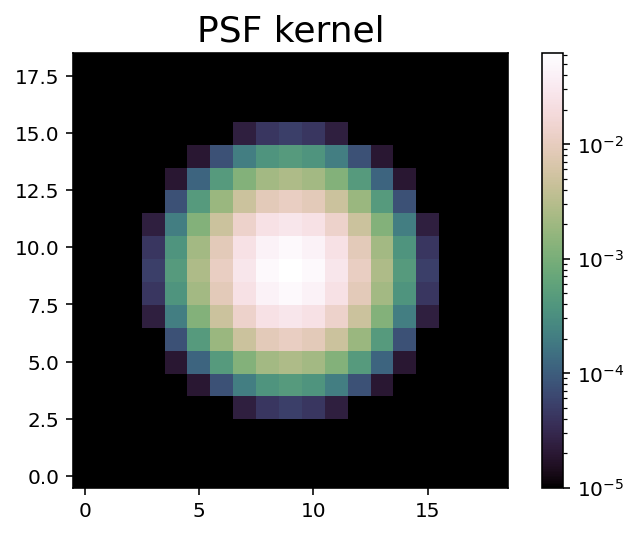

In [4]:
# Gaussian PSF
psf = PSF(psf_type='GAUSSIAN', fwhm=0.3, truncation=5, pixel_size=pix_scl)

plt.figure()
plt.title("PSF kernel", fontsize=18)
plt.imshow(psf.kernel_point_source, origin='lower', cmap=plotter.cmap_flux, norm=LogNorm(1e-5))
plt.colorbar()
plt.show()

# Noise
exp_time, sigma_bkd = 9600., 0.005  # same values as for MOLET simulations

noise = Noise(npix, npix, background_rms=sigma_bkd, exposure_time=exp_time)
noise_fit = deepcopy(noise)

### Mass and light models

In [5]:
# Input lens mass model 
kwargs_macro_lens_input = {'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0}
kwargs_ext_shear_input = {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0., 'dec_0': 0.}
phi_ext, gamma_ext = param_util.shear_cartesian2polar(kwargs_ext_shear_input['gamma1'], kwargs_ext_shear_input['gamma2'])
#print(f"Input shear strength: {gamma_ext:.3f} & direction: {phi_ext*180/np.pi:.3f}")
phi, q = param_util.ellipticity2phi_q(kwargs_macro_lens_input['e1'], kwargs_macro_lens_input['e2'])
#print(f"Input macro axis ratio: {q:.3f} & direction: {phi*180/np.pi:.3f}")

# Grid on which pixelated (input) perturbation are evaluated
kwargs_pixelated_lens_numerics = {
    'pixel_scale_factor': 1.,  # if 1 / n, it means n times better resolved
}
pixel_grid.create_model_grid(**kwargs_pixelated_lens_numerics, 
                             name='lens_numerics', overwrite=True)
npix_num, _ = pixel_grid.model_pixel_shape('lens_numerics')
pix_scl_num = pixel_grid.model_pixel_width('lens_numerics')

# Input potential perturbations
if 'dark_halo' in perturbation_type:
    lens_mass_model_input = LensModel(['SIE', 'SHEAR', 'SIE'])
    kwargs_lens_input = [
        kwargs_macro_lens_input, 
        kwargs_ext_shear_input,
        {'theta_E': 0.07, 'e1': 0.0, 'e2': 0.0, 'center_x': 1.9, 'center_y': -0.4}
    ]
    phi_p, q_p = param_util.ellipticity2phi_q(kwargs_lens_input[-1]['e1'], kwargs_lens_input[-1]['e2'])
    print(f"Input halo axis ratio: {q_p:.3f} & direction: {phi_p*180/np.pi:.3f}")
    
elif 'discyness' in perturbation_type or 'boxyness' in perturbation_type:
    lens_mass_model_input = LensModel(['SIE', 'SHEAR', 'MULTIPOLE'])
    phi_macro_lens, _ = param_util.ellipticity2phi_q(kwargs_macro_lens_input['e1'], 
                                                     kwargs_macro_lens_input['e2'])
    print("phi_macro_lens", phi_macro_lens)
    if 'large' in perturbation_type:
        a_m = 0.12
    else:
        a_m = 0.06  # multipole strength: value corresponding to the high-end of Hao et al. 2006's distribution
    if 'discyness' in perturbation_type:
        phi_shift = 0
    elif 'boxyness' in perturbation_type:
        phi_shift = 45*np.pi/180.
    kwargs_lens_input = [
        kwargs_macro_lens_input, 
        kwargs_ext_shear_input,
        {'m': 4, 'a_m': a_m, 'phi_m': phi_macro_lens + phi_shift, 'center_x': 0.0, 'center_y': 0.0}
    ]
    
elif 'GRF' in perturbation_type:
    
    seed = 33
    
    beta = -4
    sigma2_grf = 1e-3
    psi_grid_input_orig = grf_util.gauss_rand_2d(npix_num, npix_num,
                                                 npix_num*pix_scl_num, npix_num*pix_scl_num,
                                                 sigma2_grf, beta, seed=seed)
    norm_grf = grf_util.grf_normalization(npix_num, npix_num,
                                          npix_num*pix_scl_num, npix_num*pix_scl_num,
                                          beta)
    #print("norm. constant:", norm_grf)
    
    print("mean value:", psi_grid_input_orig.mean())
    lens_mass_model_input = LensModel(['SIE', 'SHEAR', 'PIXELATED'],
                                      kwargs_pixelated=kwargs_pixelated_lens_numerics)
    kwargs_lens_input = [
        kwargs_macro_lens_input, 
        kwargs_ext_shear_input,
        {'pixels': psi_grid_input_orig},
    ]
    
    # Generate a mask
    rmin = 0.8
    rmax = 2.8
    x_grid_num, y_grid_num = pixel_grid.model_pixel_coordinates('lens_numerics')
    radius_num = np.hypot(x_grid_num, y_grid_num)
    mask_num = ((radius_num >= rmin) & (radius_num <= rmax)).astype(float)
    
    plt.figure()
    plt.title(np.log10(np.var(psi_grid_input_orig[mask_num == 1])))
    plt.imshow(psi_grid_input_orig, origin='lower', norm=TwoSlopeNorm(0))
    plt.colorbar()
    plt.contour(mask_num, levels=[1])
    plt.show()

# Fitted lens mass model
kwargs_pixelated_lens = {'pixel_scale_factor': potential_pixel_scale}
lens_mass_model_fit = LensModel(['SIE', 'SHEAR', 'PIXELATED'],
                                kwargs_pixelated=kwargs_pixelated_lens)

# Input source model
source_model_input = LightModel(['SERSIC_ELLIPSE'])
kwargs_source_input = [
    {'amp': 11.12, 'R_sersic': 0.8, 'n_sersic': 1.5, 'e1': -0.09, 'e2': 0.03,
     'center_x': 0.4, 'center_y': 0.15}
]

phi_src, q_src = param_util.ellipticity2phi_q(kwargs_source_input[0]['e1'], kwargs_source_input[0]['e2'])
print(f"Input source axis ratio: {q_src:.3f} & direction: {phi_src*180/np.pi:.3f}")

# update 'amp' based on magnitude
from scipy import special
mag_src = 21.0
mag_ZP = 25.9463
reff_src = kwargs_source_input[0]['R_sersic']
n_src = kwargs_source_input[0]['n_sersic']
b_n_src = n_src*1.9992 - 0.3271
#I_eff = \frac{b_{\rm n}^{2n}10^{-0.4(M_{\rm tot} - ZP)}}{2\pi \theta_{\rm eff}^2 \, n \, e^{b_{\rm n}} \, \Gamma(2 n ) q},
amp_from_mag = (b_n_src**(2*n_src)*10**(-0.4*(mag_src - mag_ZP))) / (2*np.pi*reff_src**2 * n_src * np.exp(b_n_src) * special.gamma(2*n_src) * q_src)
print("Computed source magnitude:", amp_from_mag)
kwargs_source_input[0]['amp'] = amp_from_mag

# Input lens light
lens_light_model_input = LightModel(['SERSIC_ELLIPSE'])
kwargs_lens_light_input = [
    {'amp': 12.6, 
     'R_sersic': 2., 'n_sersic': 2., 
     'e1': kwargs_macro_lens_input['e1'], 'e2': kwargs_macro_lens_input['e2'], 
     'center_x': kwargs_macro_lens_input['center_x'], 'center_y': kwargs_macro_lens_input['center_y']}
]


Input halo axis ratio: 1.000 & direction: 22.500
Input source axis ratio: 0.827 & direction: 80.783
Computed source magnitude: 12.581937


### Image model classes, for both simulate and fit

In [6]:
kwargs_numerics = {'supersampling_factor': 1}

# True image model
lens_image_input = LensImage(pixel_grid, psf, noise_class=noise,
                                lens_model_class=lens_mass_model_input,
                                source_model_class=source_model_input,
                                lens_light_model_class=lens_light_model_input,
                                kwargs_numerics=kwargs_numerics)

# Hybrid image model for fitting
pixel_grid_fit = deepcopy(pixel_grid)
lens_image_fit = LensImage(pixel_grid_fit, psf, noise_class=noise_fit,
                                lens_model_class=lens_mass_model_fit,
                                source_model_class=source_model_input,
                                lens_light_model_class=lens_light_model_input,
                                kwargs_numerics=kwargs_numerics, recompute_model_grids=True)

In [7]:
# Extract coordinate grids for pixelated potential
x_grid_fit, y_grid_fit = lens_image_fit.Grid.model_pixel_coordinates('lens')

# Extract coordinate grids for for supersampled source surface brightness maps
x_grid_num, y_grid_num = lens_image_fit.Grid.model_pixel_coordinates('lens_numerics')

# Extract the true perturbation potential on original
psi_grid_input = lens_image_input.LensModel.potential(x_grid_num, y_grid_num, kwargs_lens_input, k=-1)
if 'psi_grid_input_orig' in locals():
    np.testing.assert_almost_equal(psi_grid_input_orig, psi_grid_input, decimal=7)  # quick numerical check

# Extract the true perturbation potential on fitted grid
psi_grid_input_fitgrid = lens_image_input.LensModel.potential(x_grid_fit, y_grid_fit, kwargs_lens_input, k=-1)

# Mean deflection angle strength
alpha_grid_input = lens_image_input.LensModel.alpha(x_grid_num, y_grid_num, kwargs_lens_input, k=-1)
alpha_grid_input = np.hypot(*alpha_grid_input)
print("mean deflection angle:", np.abs(alpha_grid_input).mean())

mean deflection angle: 0.06999995


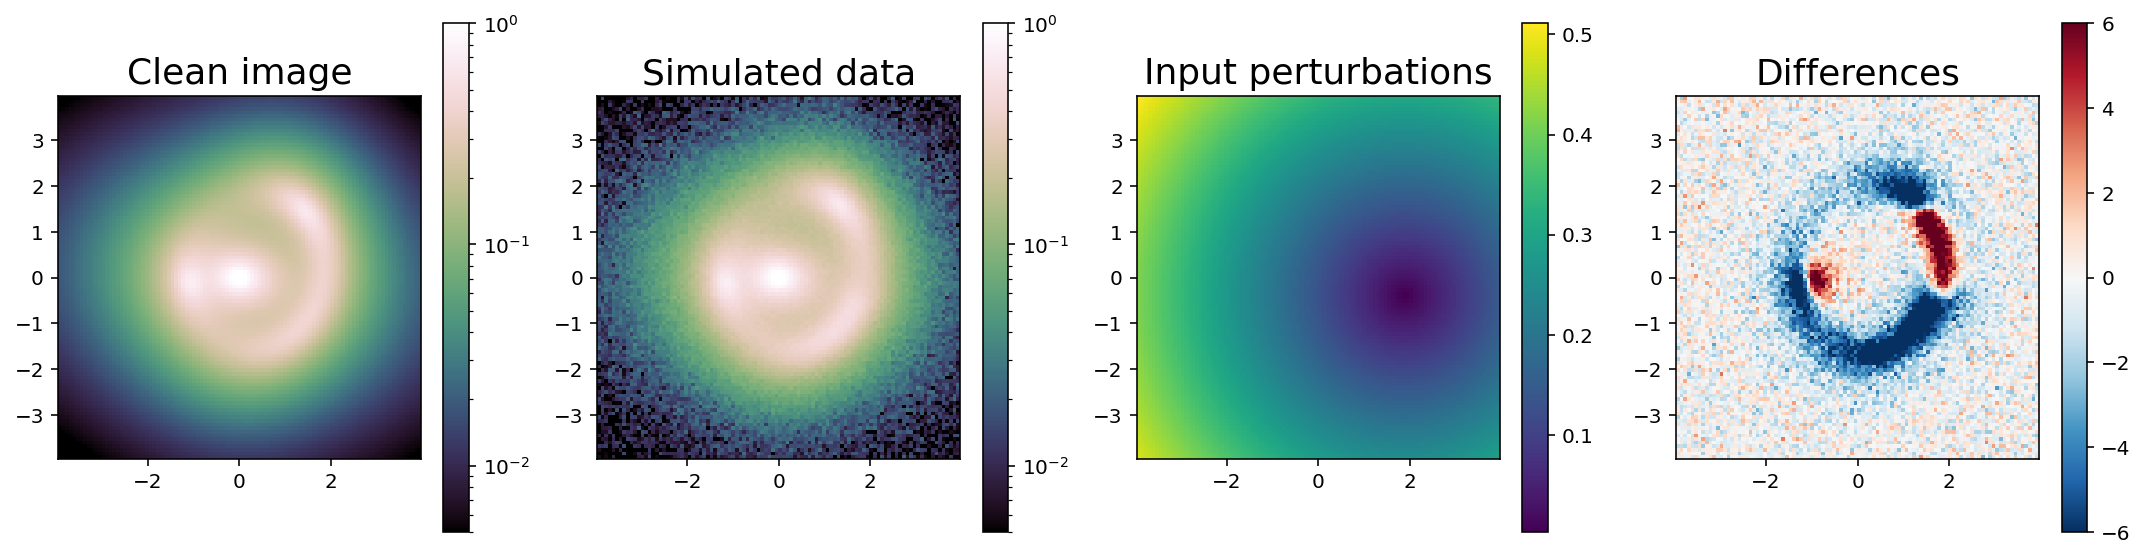

In [8]:
# Generate a lensed image based on source and lens models
clean_image = lens_image_input.model(kwargs_lens=kwargs_lens_input,
                              kwargs_source=kwargs_source_input,
                              kwargs_lens_light=kwargs_lens_light_input, k_lens=(0,1))

#testtest = lens_image_input.source_surface_brightness(kwargs_source_input, de_lensed=True, unconvolved=True, 
#                                                      k=(True,))

# Observed noisy data
data = lens_image_input.simulation(kwargs_lens=kwargs_lens_input,
                                   kwargs_source=kwargs_source_input,
                                   kwargs_lens_light=kwargs_lens_light_input,
                                   noise_seed=noise_seed)
fits.writeto(f"herculens_image_{perturbation_type}.fits", np.array(data), overwrite=True)

# here we assume that the noise is perefectly known
#lens_image_fit.Noise.set_data(clean_image)
lens_image_fit.Noise.compute_noise_map_from_model(clean_image, as_jax_array=False)

# get the true source surface brightness
source_input = lens_image_input.source_surface_brightness(kwargs_source_input,
                                                          de_lensed=True, unconvolved=True)
source_input_lensed = lens_image_input.source_surface_brightness(kwargs_source_input, kwargs_lens=kwargs_lens_input,
                                                                 de_lensed=False, unconvolved=False)

# some quantities about the perturbations
#print("sum(abs(perturbations)) =", np.abs(psi_grid_input).sum())
#print("log(var(perturbations))) =", np.log10(np.var(psi_grid_input)))

# Plot
fig, axes = plt.subplots(1, 4, figsize=(15, 4))
ax = axes[0]
ax.set_title("Clean image", fontsize=18)
im = ax.imshow(clean_image, origin='lower', extent=extent, cmap=plotter.cmap_flux, norm=plotter.norm_flux)
fig.colorbar(im, ax=ax)
ax = axes[1]
ax.set_title("Simulated data", fontsize=18)
im = ax.imshow(data, origin='lower', extent=extent, cmap=plotter.cmap_flux, norm=plotter.norm_flux)
fig.colorbar(im, ax=ax)
ax = axes[2]
ax.set_title("Input perturbations", fontsize=18)
im = ax.imshow(psi_grid_input, origin='lower', extent=extent, cmap=plotter.cmap_default)
fig.colorbar(im, ax=ax)
fig.tight_layout()
ax = axes[3]
ax.set_title("Differences", fontsize=18)
im = ax.imshow((clean_image - data) / np.sqrt(lens_image_input.Noise.C_D_model(clean_image)), origin='lower', extent=extent, cmap=plotter.cmap_res, vmin=-6, vmax=+6)
fig.colorbar(im, ax=ax)
fig.tight_layout()
plt.show()

In [9]:
if SAVE_PSI_FIELDS:
    if perturbation_type == 'dark_halo':
        perturbation_type_field = perturbation_type + '_pixel'
    # save the potential perturbation array
    hdr_pert_input = fits.Header()
    hdr_pert_input['PXSCLFAC'] = kwargs_pixelated_lens_numerics['pixel_scale_factor']
    extent_num = pixel_grid.model_pixel_extent('lens_numerics')
    hdr_pert_input['WIDTH'] = extent_num[1] - extent_num[0]
    hdr_pert_input['HEIGHT'] = extent_num[3] - extent_num[2]
    hdr_pert_fit = fits.Header()
    hdr_pert_fit['PXSCLFAC'] = kwargs_pixelated_lens['pixel_scale_factor']
    hdr_pert_fit['WIDTH'] = extent[1] - extent[0]
    hdr_pert_fit['HEIGHT'] = extent[3] - extent[2]
    hdus = fits.HDUList([
        fits.PrimaryHDU(np.array(psi_grid_input), header=hdr_pert_input), 
        fits.ImageHDU(np.array(psi_grid_input_fitgrid), header=hdr_pert_fit),
    ])
    hdus.writeto(os.path.join('molet', f'molet_sim_{perturbation_type_field}', 'input_files', f'dpsi.fits'), 
                 overwrite=True)
    
    #hdr_pert_fit = fits.Header()
    #hdr_pert_fit['PXSCLFAC'] = kwargs_pixelated_lens['pixel_scale_factor']
    #hdr_pert_fit['WIDTH'] = extent[1] - extent[0]
    #hdr_pert_fit['HEIGHT'] = extent[3] - extent[2]
    #hdus = fits.HDUList([
    #    fits.PrimaryHDU(psi_grid_input, header=hdr_pert_input), 
    #    fits.ImageHDU(psi_grid_input_fitgrid, header=hdr_pert_fit),
    #])
    #hdus.writeto(os.path.join('molet', f'molet_sim_{perturbation_type}.fits', 'input_files', f'dpsi_{perturbation_type}.fits'), overwrite=True)

## Potential perturbation fitting

### Prepare the parameters (initial values, constraints, etc.)

In [10]:
# no perturbations for first fit (small number)
psi_grid_init = 1e-8 * np.ones_like(psi_grid_input_fitgrid)
#psi_grid_init = 1e-8 * np.random.randn(*psi_grid_input_fitgrid.shape)
print("Initial perturbations:", psi_grid_init[:10, 0])

kwargs_input = {
    'kwargs_lens': [kwargs_lens_input[0], kwargs_lens_input[1], {'pixels': psi_grid_init}],
    'kwargs_source': kwargs_source_input,
    'kwargs_lens_light': [{}],
}

kwargs_init = {
    'kwargs_lens': [{}, {}, {'pixels': psi_grid_init}],
    'kwargs_source': kwargs_source_input,
    'kwargs_lens_light': [{}],
}
kwargs_fixed = {
    'kwargs_lens': [kwargs_lens_input[0], kwargs_lens_input[1], {}], 
    'kwargs_source': kwargs_source_input,
    'kwargs_lens_light': kwargs_lens_light_input,
}
kwargs_joint = {
    # fix lens center to lens light center
    'lens_with_lens_light': [[(0, 0), ['center_x', 'center_y']]],
}
parameters = Parameters(lens_image_fit, kwargs_init, kwargs_fixed, 
                        kwargs_joint=kwargs_joint, kwargs_prior=None)
print("Number of fitted parameters:", parameters.num_parameters)
print("Parameters names:", parameters.names[:10], "...")

#source_num_params = len([1 for i in range(len(kwargs_source_input)) for _ in kwargs_source_input[i].values()])

Initial perturbations: [1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08]
Number of fitted parameters: 4489
Parameters names: ['d_0', 'd_1', 'd_2', 'd_3', 'd_4', 'd_5', 'd_6', 'd_7', 'd_8', 'd_9'] ...


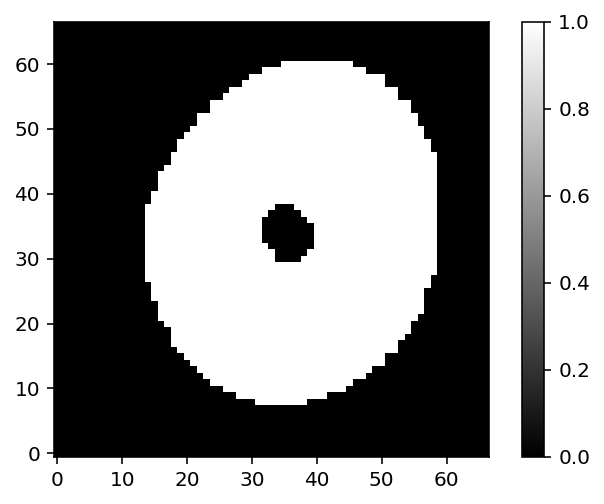

In [11]:
# generate the source mask based on SNR > 5
lensed_src = lens_image_fit.model(**kwargs_input, lens_light_add=False)
src_snr = lensed_src / np.sqrt(lens_image_fit.Noise.C_D_model(lensed_src))
src_mask = (src_snr > 5).astype(float)

# interpolate to potential grid
interp_psi_mask = jax_util.BicubicInterpolator(x_coords, y_coords, src_mask)
src_mask_interp = np.array(interp_psi_mask(y_grid_fit, x_grid_fit)).astype(bool).astype(float)

plt.figure()
plt.imshow(src_mask_interp, origin='lower', cmap='gray')
plt.colorbar()
plt.show()

In [12]:
%%time
pot_noise_st, pot_noise_bl \
    = model_util.data_noise_to_wavelet_potential(data, lens_image_fit, 
                                                 parameters.current_values(as_kwargs=True),
                                                 wavelet_type_list=['starlet', 'battle-lemarie-3'], 
                                                 method='MC', num_samples=6000, seed=8, verbose=False)

CPU times: user 1min 32s, sys: 3.8 s, total: 1min 36s
Wall time: 55.4 s


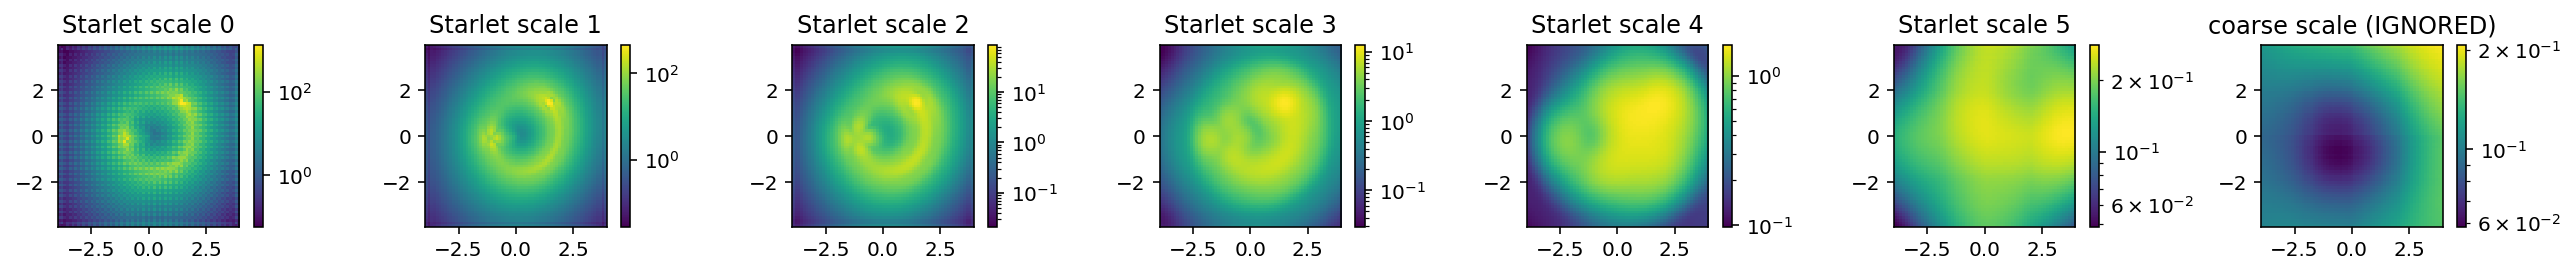

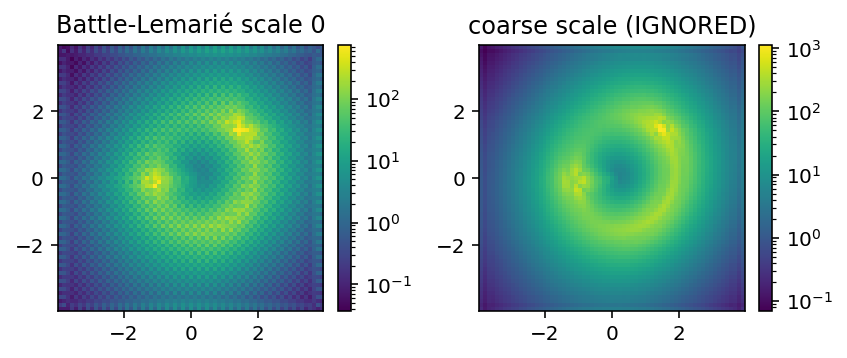

In [13]:
pot_noise_st_plot = np.copy(pot_noise_st)
pot_noise_bl_plot = np.copy(pot_noise_bl)

fig, axes = plt.subplots(1, pot_noise_st_plot.shape[0], figsize=(18, 4))
for k in range(pot_noise_st_plot.shape[0]):
    ax = axes[k]
    if k == pot_noise_st_plot.shape[0]-1:
        ax.set_title(f"coarse scale (IGNORED)")
    else:
        ax.set_title(f"Starlet scale {k}")
    im = ax.imshow(pot_noise_st_plot[k], origin='lower', extent=extent,
                   #cmap='Spectral_r', norm=TwoSlopeNorm(0)
                   cmap='viridis', norm=LogNorm()
                  )
    plot_util.nice_colorbar(im)
fig.tight_layout()
plt.show()

fig, axes = plt.subplots(1, pot_noise_bl_plot.shape[0], figsize=(6, 4))
for k in range(pot_noise_bl_plot.shape[0]):
    ax = axes[k]
    if k == pot_noise_bl_plot.shape[0]-1:
        ax.set_title(f"coarse scale (IGNORED)")
    else:
        ax.set_title(f"Battle-Lemarié scale {k}")
    im = ax.imshow(pot_noise_bl_plot[k], origin='lower', extent=extent, 
                   #cmap='Spectral_r', norm=TwoSlopeNorm(0)
                   cmap='viridis', norm=LogNorm()
                  )
    plot_util.nice_colorbar(im)
fig.tight_layout()
plt.show()

In [14]:
# Create loss
loss_pixpot_fit = Loss(data, lens_image_fit, parameters, 

                       regularization_terms=[
                           'l1_starlet_potential', 
                           'l1_battle_potential'
                       ], 
                       regularization_strengths=[
                           (3, 3), 
                           3,
                       ],
                       regularization_weights=[
                           pot_noise_st, 
                           pot_noise_bl
                       ],
                       prior_terms=None)
print("Number of data points in likelihood:", loss_pixpot_fit.likelihood_num_data_points)
print("Initial loss:", loss_pixpot_fit(parameters.current_values()))

loss_pixpot_fit.gradient(parameters.current_values()).block_until_ready();  # allows to JIT it earlier on

Number of data points in likelihood: 10000
Initial loss: 26357.566


In [15]:
optimizer_pixpot_fit = Optimizer(loss_pixpot_fit, parameters)

#optimizer_type = 'minimize'
#maxiter = 400

optimizer_type = 'optax'
maxiter = 1000

if optimizer_type == 'minimize':
    method = 'BFGS'
    #method = 'trust-krylov'
    best_fit, logL, extra_fields, runtime \
        = optimizer_pixpot_fit.minimize(method=method, maxiter=maxiter, 
                                        restart_from_init=True, 
                                        return_param_history=True)
elif optimizer_type == 'optax':
    best_fit, logL, extra_fields, runtime \
        = optimizer_pixpot_fit.optax(algorithm='adabelief',
                                     max_iterations=maxiter, 
                                     init_learning_rate=1e-3,
                                     restart_from_init=True,
                                     return_param_history=True)

print(f"Runtime: {runtime}")
print("Loss at best-fit:", loss_pixpot_fit(best_fit))

kwargs_pixpot_fit = deepcopy(parameters.best_fit_values(as_kwargs=True))

optax.adabelief: 100%|██████████| 1000/1000 [01:21<00:00, 12.22it/s]


Runtime: 81.80806612968445
Loss at best-fit: 6864.2656


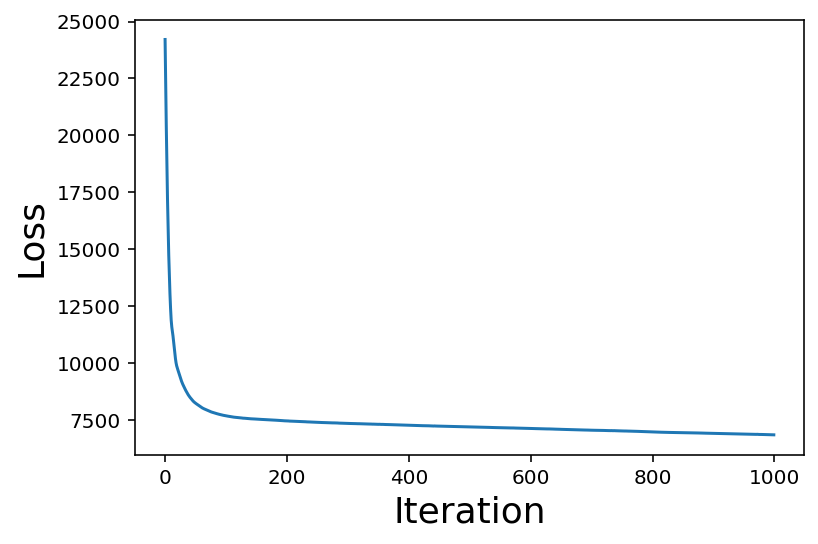

In [16]:
fig, ax = plt.subplots(1, 1)
ax.plot(range(len(extra_fields['loss_history'])), extra_fields['loss_history'])
ax.set_ylabel("Loss", fontsize=18)
ax.set_xlabel("Iteration", fontsize=18)
plt.show()

delta_psi shift by min: -0.08854685


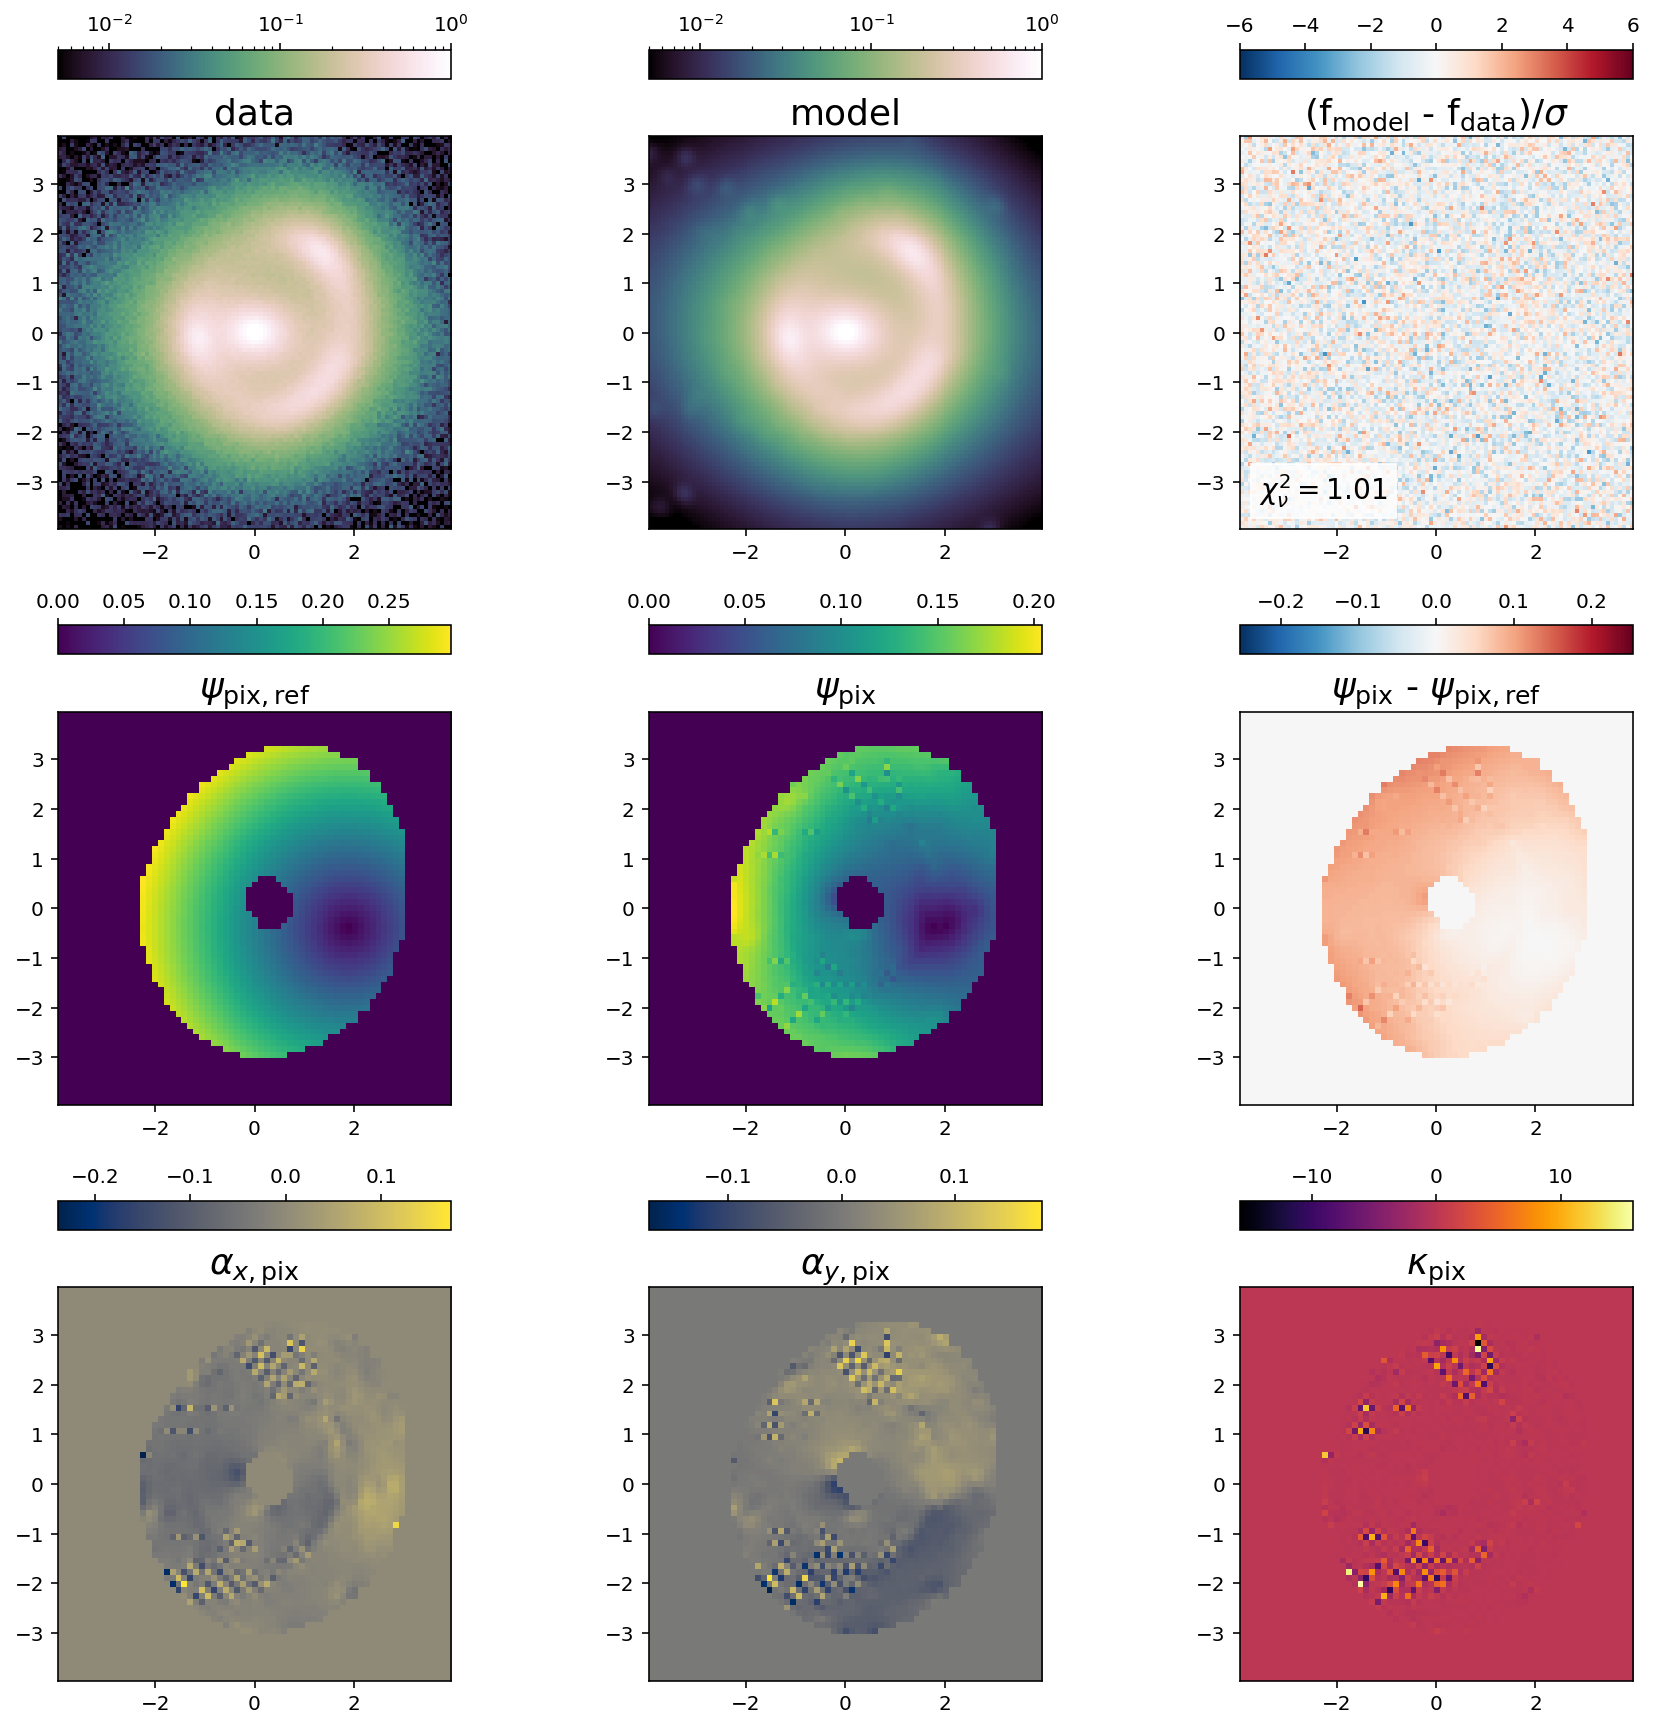

In [17]:
plotter.set_data(data)
plotter.set_ref_source(source_input)
plotter.set_ref_pixelated_potential(psi_grid_input_fitgrid)
fig = plotter.model_summary(lens_image_fit, kwargs_pixpot_fit,
                            show_source=False, show_lens_potential=True, show_lens_others=True, 
                            potential_mask=src_mask_interp,
                            shift_pixelated_potential='min',
                            #vmin_pot=-0.1, vmax_pot=0.1,
                            )

In [18]:
print(kwargs_pixpot_fit['kwargs_lens'][:2])
print(kwargs_pixpot_fit['kwargs_lens'][-1]['pixels'][:10, 0])
print(kwargs_pixpot_fit['kwargs_source'][0])

[{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0}, {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0}]
[0.20460339 0.24411501 0.40316162 0.23771447 0.1708353  0.12851743
 0.13223079 0.14839424 0.15295814 0.12814486]
{'amp': array(12.581937, dtype=float32), 'R_sersic': 0.8, 'n_sersic': 1.5, 'e1': -0.09, 'e2': 0.03, 'center_x': 0.4, 'center_y': 0.15}


## Save gradient descent movie

In [19]:
if 'best_fit_index' in extra_fields:
    run_idx = extra_fields['best_fit_index']
    loss_history = extra_fields['loss_history_list'][run_idx]
    param_history = extra_fields['param_history_list'][run_idx]
else:
    run_idx = None
    loss_history = extra_fields['loss_history']
    param_history = extra_fields['param_history']
num_steps = len(loss_history)

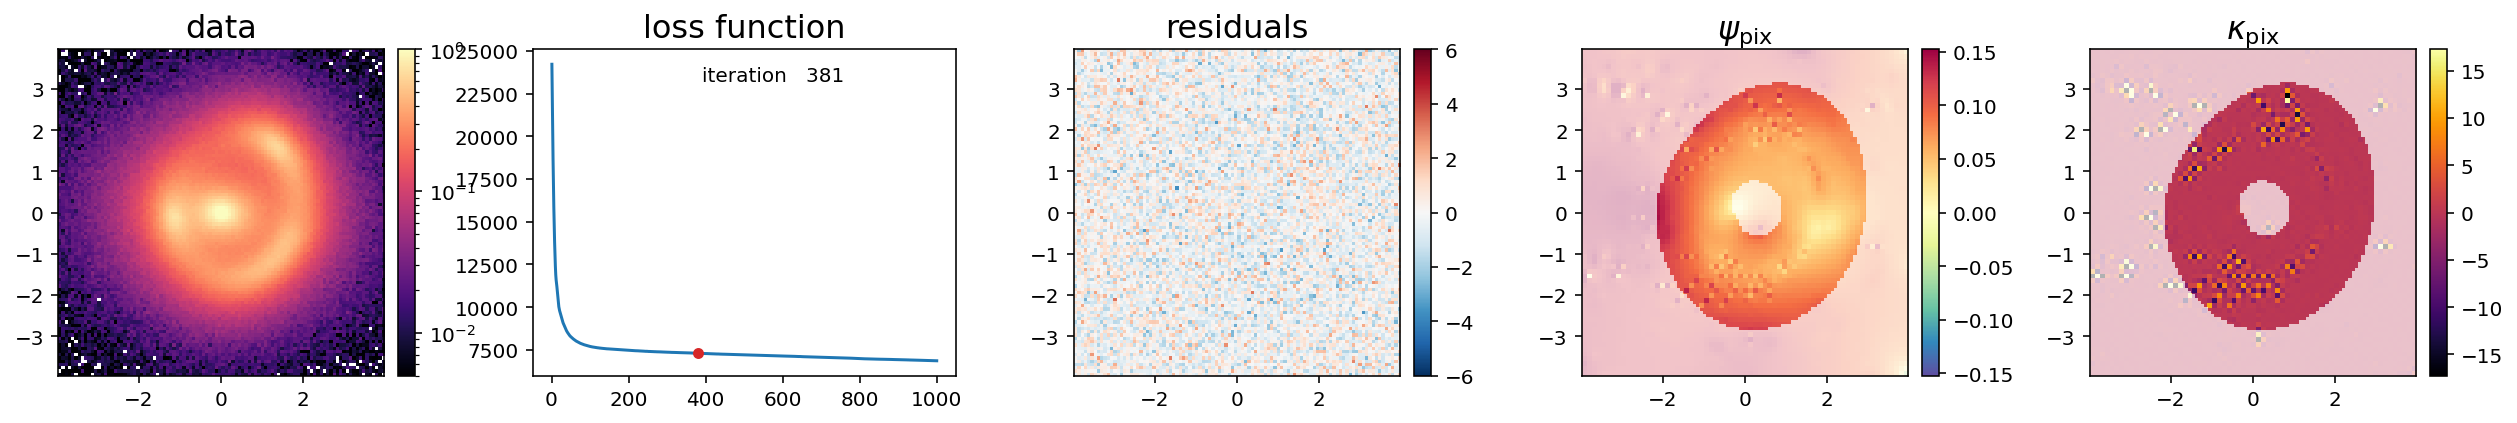

In [20]:
def make_gif(list_files, output_path, duration=100, loop=1):
    frames = [Image.open(image) for image in list_files]
    frame_one = frames[0]
    frame_one.save(output_path, format="GIF", append_images=frames,
                   save_all=True, duration=duration, loop=loop)

def create_fig(i, args):
    kwargs = parameters.args2kwargs(args)
    model = lens_image_fit.model(**kwargs)
    norm_res = lens_image_fit.normalized_residuals(data, model)
    psipix_model = np.array(kwargs['kwargs_lens'][-1]['pixels'])
    psipix_model = psipix_model.reshape(*x_grid_fit.shape)
    
    if 'dark_halo' in perturbation_type:
        psipix_model_o = psipix_model - psipix_model[src_mask_interp == 1].min()
    else:
        psipix_model_o = psipix_model
    vmax_psi = np.abs(psipix_model_o[src_mask_interp == 1]).max()
    norm_psi = Normalize(-vmax_psi, vmax_psi)
    
    x_grid_lens, y_grid_lens = lens_image_fit.Grid.model_pixel_coordinates('lens')
    
    kappapix_model = lens_image_fit.LensModel.kappa(x_grid_lens, y_grid_lens, kwargs['kwargs_lens'], k=-1)
    vmax_kappa = kappapix_model[src_mask_interp == 1].max()
    norm_kappa = Normalize(-vmax_kappa, vmax_kappa)
    
    mask_nans = np.nan * np.ones_like(src_mask)
    mask_nans[src_mask == 0] = 1
    
    fontsize = 16
    
    fig, axes = plt.subplots(1, 5, figsize=(22, 3))
    ax = axes[0]
    ax.set_title("data", fontsize=fontsize)
    im = ax.imshow(data, extent=extent, cmap='magma', norm=LogNorm(5e-3, 1e0))
    plot_util.nice_colorbar(im)
    ax = axes[1]
    ax.set_title("loss function", fontsize=fontsize)
    ax.plot(range(1, num_steps+1), loss_history, zorder=5)
    ax.text(0.4, 0.95, f"iteration {i+1:5.0f}", va='top', ha='left', transform=ax.transAxes)
    if i > 0:
        ax.scatter([i], [loss_history[i-1]], c='tab:red', s=20, marker='o', zorder=10)
    #ax.set_aspect(1./ax.get_data_ratio(), adjustable='box')
    ax = axes[2]
    ax.set_title("residuals", fontsize=fontsize)
    im = ax.imshow(norm_res, extent=extent, cmap='RdBu_r', norm=Normalize(-6, 6))
    plot_util.nice_colorbar(im)
    ax = axes[3]
    ax.set_title(r"$\psi_{\rm pix}$", fontsize=fontsize)
    im = ax.imshow(psipix_model_o, extent=extent, cmap='Spectral_r', norm=norm_psi)
    ax.imshow(mask_nans, extent=extent, cmap='gray', norm=Normalize(0, 1), alpha=0.7)
    plot_util.nice_colorbar(im)
    ax = axes[4]
    ax.set_title(r"$\kappa_{\rm pix}$", fontsize=fontsize)
    im = ax.imshow(kappapix_model, extent=extent, cmap='inferno', norm=norm_kappa)
    ax.imshow(mask_nans, extent=extent, cmap='gray', norm=Normalize(0, 1), alpha=0.7)
    plot_util.nice_colorbar(im)
    #fig.tight_layout()
    #plt.show()
    return fig

#fig = create_fig(0, parameters.initial_values())
fig = create_fig(380, param_history[380])
#plt.close(fig)

In [21]:
if SAVE_ANIM:
    file_path_list = []
    for i in tqdm(range(num_steps+1), desc='saveing plots', total=num_steps+1):
        if i == 0:
            # initial values
            args = parameters.initial_values(as_kwargs=False)
        else:
            args = param_history[i-1]  # i-1 because it does not contain initial step
        fig = create_fig(i, args)
        file_path = os.path.join('animations', f'tmp_frame_{i:05d}.jpg')
        fig.savefig(file_path, dpi=72, bbox_inches=0, transparent=False)
        plt.close(fig)  # import to remove figure from memory
        file_path_list.append(file_path)

In [22]:
if SAVE_ANIM:
    # create the gif based on saved plots
    make_gif(file_path_list, os.path.join('animations', f'anim-ideal-{perturbation_type}.gif'),
             duration=50)

## Extract covariance matrix

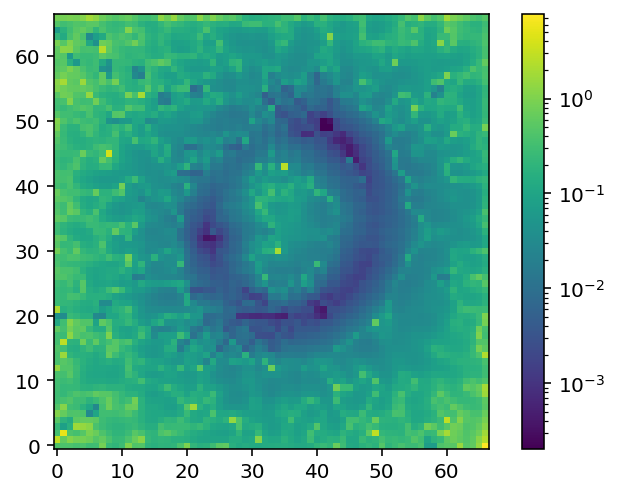

In [23]:
# Fisher information matrix
model_covar_pixpot = FisherCovariance(parameters, loss_pixpot_fit)
model_covar_pixpot.compute_fisher_information(recompute=True)  # can take time
fisher_pixpot = model_covar_pixpot.fisher_matrix

# covariance matrices
cov_matrix_pixpot = model_covar_pixpot.fisher2covar(fisher_pixpot, inversion='diag')

plt.imshow(np.sqrt(np.abs(cov_matrix_pixpot)).reshape(*psi_grid_input_fitgrid.shape), 
           origin='lower', norm=LogNorm())
plt.colorbar()
plt.show()

In [24]:
if stop_after_optim:
    raise

RuntimeError: No active exception to reraise

## HMC sampling

In [ ]:
from herculens.Inference.sampling import Sampler

sampler = Sampler(loss_pixpot_fit, parameters)

In [ ]:
seed_hmc = 10
inv_mass_matrix = None #fisher_pixpot

samples_hmc, logL, extra_fields, runtime \
    = sampler.hmc_blackjax(seed_hmc, num_warmup=50, num_samples=200, num_chains=1, 
                           restart_from_init=False, sampler_type='NUTS', use_stan_warmup=True,
                           step_size=1e-3, inv_mass_matrix=inv_mass_matrix, num_integ_steps=30)
print(f"Runtime: {runtime}")
print(f"Samples shape: {samples_hmc.shape}")

In [ ]:
covariance_hmc = np.cov(samples_hmc.T)

In [ ]:
np.diag(covariance_hmc)

In [ ]:
plt.hist(samples_hmc[:, 501])

In [ ]:
median_hmc = np.median(samples_hmc, axis=0).reshape(*psi_grid_input_fitgrid.shape)
error_map_hmc = np.sqrt(np.diag(covariance_hmc)).reshape(*psi_grid_input_fitgrid.shape)
#plt.imshow(np.abs(median_hmc * src_mask_interp / error_map_hmc), origin='lower')
plt.imshow(error_map_hmc * src_mask_interp, origin='lower')
#plt.matshow(fisher_pixpot_chi2 - fisher_pixpot)
#plt.matshow(fisher_pixpot_chi2 - fisher_pixpot)
plt.colorbar()
plt.show()

In [ ]:
print(extra_fields['inverse_mass_matrix'])
print(np.diag(fisher_pixpot))

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(range(len(logL)), logL)
ax.set_ylabel("Loss", fontsize=18)
ax.set_xlabel("Samples", fontsize=18)
plt.show()

## Save results for plotting

In [ ]:
base_filename = f'-{perturbation_type}-scale_{potential_pixel_scale}-smooth_source'

if SAVE_MODELS:
    with open(os.path.join('results', 'sumplot-ideal'+base_filename+'.pkl'), 'wb') as f:
        pkl_protocol = 2
        pkl_content = [
            # data
            data,
            
            # model
            lens_image_fit, 
            
            # parameter values
            kwargs_pixpot_fit, 
            kwargs_input,
            
            # pixelated potential
            src_mask_interp,
            None, #potential_noise_map,
            psi_grid_input,
            psi_grid_input_fitgrid,
            
            # error estimations
            None, #full_fisher_matrix,
            cov_matrix_pixpot,
            None,
            
            # parameter vectors for corner plot
            None,
            None,
            None,
        ]
        pkl.dump(pkl_content, f, pkl_protocol)